In [1]:
#this script computes flow law parameters for river discharge
# by Mike, October 6, 2021

In [2]:
# the "using" function pulls in the Julia libraries we need
using Pkg
using JuMP
using Ipopt
using Plots

In [3]:
# these are data derived from commercial high-resolution imagery for the Meade on the North Slope of Alaska
H=[7.328456	6.565949	5.961361	6.251553	5.878249	5.567565	6.007122	5.417301	6.191109	6.521737	6.039580	5.830678]	
W=[177.259919	155.598992	130.974720	141.695858	121.505408	103.903389	127.263053	86.457151	138.305701	147.369275	126.712752	126.784003	]
S=10e-5 #we're assuming slope is constant in time

nt=12

#this is discharge at streamgage corresponding to data above https://waterdata.usgs.gov/nwis/inventory/?site_no=15803000
Qgage=[161.406026	46.439628	27.835460	30.299026	10.760402	5.578419	35.112890	1.514951	47.289134	51.253492	30.582194	7.673865	]
Qgage=reshape(Qgage,(12,) ); #note adding some semicolons throughout to suppress random output

In [4]:
# we will fit this form of Manning's equation:
# Q=1/n* (H-H0)^(5/3) W S^(1/2)
#    where n is friction coefficient
#          H is observed water surface elevation
#          H0 is an offset, notionally the river bathymetric elevation
#          W is river top width
#          S is river slope

#parameter bounds
nmin=0.01 #we don't want n to go below this value

# we don't want H-H0 to be negative! to accomplish that, we can specify a maximum value for H0
#  because if H0 gets too big, then H-H0 goes negative. the limiting case is for the lowest 
#  value of H.

Dmin=0.1 #this is a notional minimum value for "depth"
# D=H-H0, so H0min=minimum value of H -Dmin
H0max=minimum(H)-Dmin

# there are two parameters to estimate: n and H0
m = Model(optimizer_with_attributes(Ipopt.Optimizer))
@variable(m,n>=nmin)
@variable(m,H0<=H0max)
@variable(m,Q[i=1:nt]>=0)
#@variable(m,err[i=1:nt]>=0)

for i=1:nt
    @NLconstraint(m,Q[i]==1/n*(H[i]-H0)^(5/3)*W[i]*S^0.5 )
    #@constraint(m,err[i]==Qgage[i]-Q[i])
end

@objective(m,Min, sum( (Qgage-Q).^2 ) ) ;

In [5]:
optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       36
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:       14
                     variables with only lower bounds:       13
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        1
Total number of equal

In [6]:
#let's check out the optimal solution!

H0hat=JuMP.value.(H0)
println(H0hat)
nhat=JuMP.value.(n)
println(nhat)
Qhat=JuMP.value.(Q);

5.213920299997282
0.03975434177917841


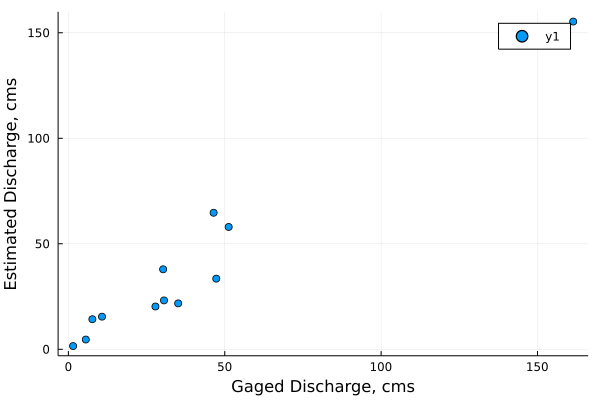

In [7]:
plot(Qgage,Qhat,seriestype = :scatter)
xlabel!("Gaged Discharge, cms")
ylabel!("Estimated Discharge, cms")